In [2]:
%%bash

# Download the dataset if it's not already there

# Dataset: 
# Amazon Reviews for Home and Kitchen Appliances

# Paper: 
# Justifying recommendations using distantly-labeled reviews and fined-grained aspects
# Jianmo Ni, Jiacheng Li, Julian McAuley
# Empirical Methods in Natural Language Processing (EMNLP), 2019


if [ ! -f "./Appliances.json" ]; then
    curl "https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/Appliances.json.gz" | gunzip > Appliances.json
else
    echo "Dataset already downloaded."
fi


Dataset already downloaded.


In [3]:
%matplotlib inline

import pandas as pd

In [4]:
df_raw = pd.read_json("Appliances.json", lines=True)

In [5]:
memuse = df_raw.memory_usage(deep=True).sum() / 1024**2
print(f"Memory usage before Data Cleaning: {memuse:.2f} MB")

Memory usage before Data Cleaning: 430.16 MB


In [6]:
# Data Cleaning

# drop columns that are not needed and drop rows with missing values
df = df_raw.drop(['verified', 'reviewTime', 'reviewerID', 'asin', 'style', 'reviewerName', 'unixReviewTime', 'vote', 'image'], axis=1).dropna()

# convert the text columns to string
df["reviewText"] = df["reviewText"].astype("string")
df["summary"] = df["summary"].astype("string")

# convert the overall column [1-5] to uint8 
df["overall"] = df["overall"].astype("uint8")

In [7]:
memuse_clean = df.memory_usage(deep=True).sum() / 1024**2
print(f"Memory usage after Data Cleaning: {memuse_clean:.2f} MB")

Memory usage after Data Cleaning: 192.62 MB


In [8]:
df.head()

,overall,reviewText,summary
0,5,Not one thing in this book seemed an obvious o...,Clear on what leads to innovation
1,5,I have enjoyed Dr. Alan Gregerman's weekly blo...,Becoming more innovative by opening yourself t...
2,5,Alan Gregerman believes that innovation comes ...,The World from Different Perspectives
3,5,"Alan Gregerman is a smart, funny, entertaining...",Strangers are Your New Best Friends
4,5,"As I began to read this book, I was again remi...","How and why it is imperative to engage, learn ..."


/var/folders/3g/xl748sgd3ljgqvnxwbdt3vn80000gn/T/ipykernel_14558/3033069696.py:2: FutureWarning: `sort_columns` is deprecated and will be removed in a future version.
  df["overall"].value_counts().plot(kind="bar", title="Distribution of Overall Rating", xlabel="Rating", ylabel="Count", rot=0, sort_columns=True)


<Axes: title={'center': 'Distribution of Overall Rating'}, xlabel='Rating', ylabel='Count'>

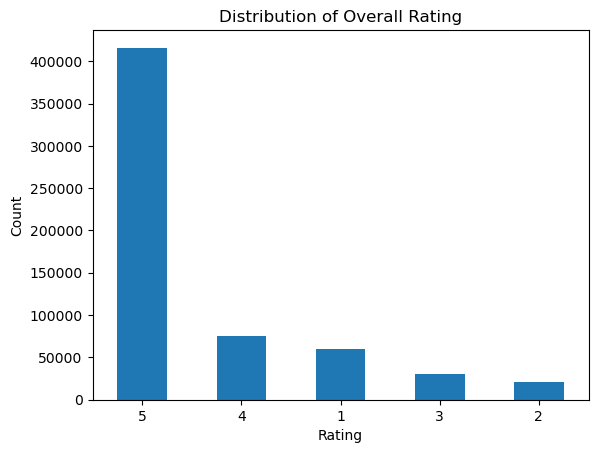

In [9]:
# plot the distribution of the overall rating, we can see that the dataset is imbalanced
df["overall"].value_counts().plot(kind="bar", title="Distribution of Overall Rating", xlabel="Rating", ylabel="Count", rot=0, sort_columns=True)

/var/folders/3g/xl748sgd3ljgqvnxwbdt3vn80000gn/T/ipykernel_14558/94216261.py:9: FutureWarning: `sort_columns` is deprecated and will be removed in a future version.
  rdf["overall"].value_counts().plot(kind="bar", title="Distribution of Overall Rating", xlabel="Rating", ylabel="Count", rot=0, sort_columns=True)


<Axes: title={'center': 'Distribution of Overall Rating'}, xlabel='Rating', ylabel='Count'>

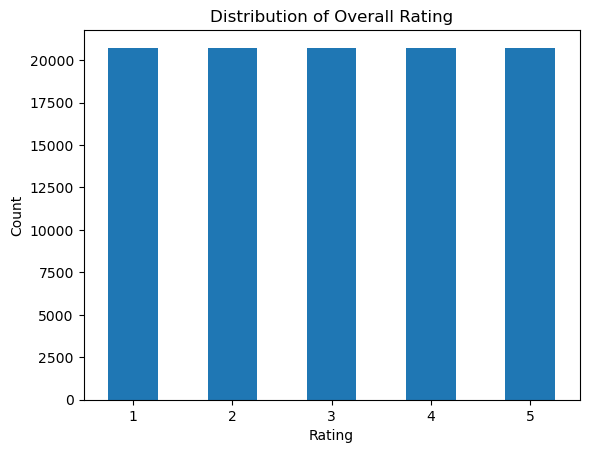

In [10]:
# create a balanced dataset by sampling N reviews from each rating
# N is the count of reviews least represented in the dataset

N = df["overall"].value_counts().min()

rdf = df.groupby("overall").apply(lambda x: x.sample(n=N, random_state=42)).reset_index(drop=True)

# plot the distribution of the overall rating, we can see that the dataset is balanced
rdf["overall"].value_counts().plot(kind="bar", title="Distribution of Overall Rating", xlabel="Rating", ylabel="Count", rot=0, sort_columns=True)


In [11]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# download the nltk packages
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# create a lemmatizer
lemmatizer = WordNetLemmatizer()

# create a list of stop words
stop_words = stopwords.words('english')

for str_col in ["reviewText", "summary"]:

  # create a list of texts
  texts = rdf[str_col].tolist()

  # tokenize the texts
  tokenized_texts = [word_tokenize(text) for text in texts]

  # remove stop words and lemmatize the tokens

  lemmatized_texts = [[lemmatizer.lemmatize(token.lower()) for token in text if token.lower() not in stop_words] for text in tokenized_texts]

  # join the tokens back to text
  joined_texts = [" ".join(text) for text in lemmatized_texts]

  # create a new column for the cleaned text
  rdf[f"{str_col}_cleaned"] = joined_texts

[nltk_data] Downloading package punkt to /Users/rmn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/rmn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/rmn/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/rmn/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [12]:
strcols = ["reviewText", "reviewText_cleaned", "summary", "summary_cleaned"]
idx = 100

for col in strcols:
  print(f"{col}\n\t{rdf[col][idx]}")

reviewText
	Deceptive product presentation. DO NOT ORDER THIS PART. IT DOES NOT COME WITH THE PART THAT BREAKS - THE HANDLE. This is the second time this part has broken on my dishwasher. I managed to order the right part the first time by using this part number. Now, apparently, I have to order an "assembly." Really? My only mistake was not reading the reviews before ordering. It's apparent hey've stuck other customers, too, collected their shipping fees and their 20% restocking fee and left us with a dishwasher that was still broken. Probably the last time I'll order appliance parts from Amazon. Fool me once......
reviewText_cleaned
	deceptive product presentation . order part . come part break - handle . second time part broken dishwasher . managed order right part first time using part number . , apparently , order `` assembly . '' really ? mistake reading review ordering . 's apparent hey 've stuck customer , , collected shipping fee 20 % restocking fee left u dishwasher still bro

In [13]:
# create a dictionary of words from the cleaned texts, and count the number of occurences of each word
from collections import Counter

word_counts = Counter()

cleaned_cols = ["reviewText_cleaned", "summary_cleaned"]

for col in cleaned_cols:
  for text in rdf[col].tolist():
    word_counts.update(text.split())

print(f"Number of unique words: {len(word_counts)}")
print(f"Most common words: {word_counts.most_common(30)}")

Number of unique words: 50552
Most common words: [('.', 337612), (',', 153066), ('!', 42110), ("n't", 41667), ('one', 35718), ('filter', 32920), ('star', 31798), ('work', 31764), ('water', 27492), ('fit', 23171), ('great', 21729), ('good', 21561), ('would', 20709), ('...', 20528), ('product', 20254), ("'s", 20248), ('part', 19244), (')', 18544), ('(', 18062), ('time', 17166), ('like', 16820), ('get', 16467), ('ice', 13880), ("''", 13878), ('well', 13774), ('use', 12809), ('two', 12337), ('month', 12253), ('year', 11770), ('buy', 11181)]


In [14]:
# create a one hot encoding for the words
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

# create a list of words that occur more than 100 times
vocab = [word for word, count in word_counts.items() if count > 125]

# fit the MultiLabelBinarizer to the vocab
mlb.fit([vocab])

# transform the cleaned texts to one hot encoding
X = mlb.transform(rdf["summary_cleaned"].tolist())

# create a dataframe from the one hot encoding
X_df = pd.DataFrame(X, columns=  mlb.classes_)
X_df.head()


/Users/rmn/miniconda3/envs/DataScience/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) [' ', '\\', '^', '_', '`', 'a', 'd', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'w', 'y', 'z', '|', '}', '~', '\x7f'] will be ignored
  warnings.warn(


,!,#,$,%,&,','','d,'ll,'m,...,year,yellow,yes,yesterday,yet,youtube,youve,yr,zero,zip
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
rdf.rename(columns={"overall": "TARGET"}, inplace=True)

df_summary = pd.concat([rdf["TARGET"], rdf["summary"], rdf["summary_cleaned"], X_df], axis=1)
df_summary.describe()

,TARGET,!,#,$,%,&,','','d,'ll,...,year,yellow,yes,yesterday,yet,youtube,youve,yr,zero,zip
count,103645.00000,103645.000000,103645.000000,103645.000000,103645.000000,103645.000000,103645.000000,103645.0,103645.0,103645.0,...,103645.0,103645.0,103645.0,103645.0,103645.0,103645.0,103645.0,103645.0,103645.0,103645.0
mean,3.00000,0.071185,0.001003,0.003502,0.000907,0.003155,0.071890,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,1.41422,0.257135,0.031661,0.059077,0.030102,0.056081,0.258306,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,2.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,3.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,4.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,5.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
df_summary

,TARGET,summary,summary_cleaned,!,#,$,%,&,','',...,year,yellow,yes,yesterday,yet,youtube,youve,yr,zero,zip
0,1,This software is buggy. I can't understand why...,software buggy . ca n't understand ...,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,Kegerator controller,kegerator controller,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,One Star,one star,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,One Star,one star,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,Worst piece of junk ever,worst piece junk ever,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103640,5,Work great. Just cut to fit and put in the oven.,work great . cut fit put oven .,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
103641,5,Five Stars,five star,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
103642,5,No comment,comment,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
103643,5,I will buy again,buy,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# create X_test, X_train, y_test, y_train from the dataframe
# overall rating is the target variable
# the one hot encoding of the summary is the feature
# ignore the summary and summary_cleaned columns
# use a 50/50 split for the train and test sets

from sklearn.model_selection import train_test_split

X = df_summary.drop(["TARGET", "summary", "summary_cleaned"], axis=1)
y = df_summary["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)


In [18]:
# create a baseline model using random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rfc = RandomForestClassifier(
    n_estimators=100,
    random_state=42
  )

rfc.fit(X_train, y_train)

# evaluate the baseline model
y_pred = rfc.predict(X_test)

print(classification_report(y_test, y_pred))




              precision    recall  f1-score   support

           1       0.32      0.29      0.30     10238
           2       0.39      0.40      0.39     10476
           3       0.36      0.44      0.40     10411
           4       0.50      0.47      0.48     10443
           5       0.64      0.56      0.60     10255

    accuracy                           0.43     51823
   macro avg       0.44      0.43      0.44     51823
weighted avg       0.44      0.43      0.44     51823



In [19]:
# create a baseline model using logistic regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    random_state=42
  )

lr.fit(X_train, y_train)

# evaluate the baseline model
y_pred = lr.predict(X_test)

print(classification_report(y_test, y_pred))


/Users/rmn/miniconda3/envs/DataScience/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           1       0.29      0.27      0.28     10238
           2       0.46      0.30      0.36     10476
           3       0.33      0.46      0.38     10411
           4       0.51      0.41      0.46     10443
           5       0.49      0.60      0.54     10255

    accuracy                           0.41     51823
   macro avg       0.42      0.41      0.40     51823
weighted avg       0.42      0.41      0.40     51823



In [20]:
# create a baseline model using naive bayes
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()

nb.fit(X_train, y_train)

# evaluate the baseline model
y_pred = nb.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.25      0.30      0.28     10238
           2       0.27      0.10      0.15     10476
           3       0.33      0.46      0.39     10411
           4       0.46      0.45      0.46     10443
           5       0.53      0.56      0.55     10255

    accuracy                           0.37     51823
   macro avg       0.37      0.38      0.36     51823
weighted avg       0.37      0.37      0.36     51823



In [21]:
# # create a baseline model using support vector machine

# from sklearn.svm import SVC

# svc = SVC()

# svc.fit(X_train, y_train)

# # evaluate the baseline model
# y_pred = svc.predict(X_test)

# print(classification_report(y_test, y_pred))

In [ ]:
# create a baseline model using a neural network

from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(100),
    random_state=42
  )

mlp.fit(X_train, y_train)

# evaluate the baseline model
y_pred = mlp.predict(X_test)

print(classification_report(y_test, y_pred))